# Scraping YouTube for Language Identification and Toxicity Detection Tasks
## Assignment #2
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

In this project we attempt to achieve the following goals:

- Creating a language dataset including Greeklish
- Crawling YouTube videos which include both Greek and Greeklish comments
- Training a language identification classifier
- Training a LLM-based toxicity classifier
- Using the LLM classifier to produce data for, and train a traditional ML toxicity classifier
- Applying our language identification and toxicity classifiers on the crawled YouTube videos and identifying interesting facts and trends

## Directory Structure

The project is structured as follows:

Main files:
- lang_identification.ipynb: is the main Jupyter Notebook containing the project code
- prompts.pdf: Supplemental material containing the prompts used for the toxicity LLM classifier
- report.pdf: Supplemental material containing Figures, Tables and analysis on the results of the project
  
Directories:
- src: a library of general functions for Data Science tasks
- tasks: task-specific modules
- data: the input data
- output: the output data (.csv)
- results: Graphs, Tables and Figures produced in the project

## Disclaimers

- Most documentation was generated by ChatGPT, and was manually corrected / augmented where necessary
- In each case where code has been obtained from outside sources, is clearly listed either in comments or in the markdown explaining the code block
- Most code implementation is "hidden" in the `src` and `tasks` modules, as stated in the section above, which contain all the documentation and implementation details

In [1]:
from time import time

start = time()

Before we begin, we need to have a baseline rule-based model which we will originally use to classify our input data. We thus create a model which predicts a text's language only using regex rules.
This classifier obviously does not need to be trained (fitted), and thus we will only use it for predictions. The implementation of our model was inspired by [this excellent LinkedIn post](https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/).

We will define our language identification task as identifiying one of three languages: Greek, English and Greeklish. We will also include an "other" category for all other languages.

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03ff\u1f00-\u1fff]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"
            else:
                for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                    match = re.search(regex_pattern, text)
                    if match:
                        pred = lang_code
                        break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


The first task we ought to complete is derive our "gold" dataset, aka the dataset on which our classifiers will be trained on.

### Greek-English identification dataset

We will begin by creating a base dataset including three of the four categories of data we defined in our language identification task (those being "Greek", "English" and "Other").

For this we will be using a subset of the [papluca language identification dataset](https://huggingface.co/datasets/papluca/language-identification), which is available to us through `huggingface`.

We download the dataset and turn it into a pandas Dataframe, so we can easily combine it with other sources later on.

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    """
    Convert a dictionary of datasets into a single pandas DataFrame.
    
    The datasets are assumed to be stored as values in the input dictionary,
    with corresponding labels as keys.
    
    :param dataset_dict: A dictionary where keys are labels and values are datasets.
    :type dataset_dict: dict
    
    :return: A concatenated pandas DataFrame with an additional 'set' column
         indicating the original label of each row.
    :rtype: pd.DataFrame
    
    :Example:
    
    .. code-block:: python
    
    >>> dataset_dict = {'A': dataset_A, 'B': dataset_B, 'C': dataset_C}
    >>> result_df = dataset_to_pd(dataset_dict)
    >>> print(result_df)
         set  ...  (columns of the datasets)
    0    A   ...  ...
    1    A   ...  ...
    ...      ...  ...
    n    C   ...  ...
    """
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


We sample a set of 2000 data records belonging to other languages and tag them as "other". The exact number is arbitrary, although in general we would like to have a size:
- large enough to contain most common words from foreign languages
- small enough to not unnecessarily burden training or bias our classifiers towards rare occurences in our operational set (the dataset which we claim little to no prior knowledge)

In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(2000)
others_df.labels = "other"
others_df

,labels,text
18882,other,不错，很好，虽然送错地点了，但是还是解决了
54679,other,给我寄的咖啡粉是2016年6月份的（18个月之前的）。而且外包装是裂开的。虐心啊！
2154,other,Il Presidente del Consiglio dei Ministri Mario...
32815,other,1946 ' de ingiliz görev personeli tarafından i...
24227,other,"Ugoda zawiera 4,1 miliona dolarów na honoraria..."
...,...,...
12579,other,カンフーシーンをもうちょい減らしていいから人物背景をもっと増やしてくれたらよかった。 特に殺...
38271,other,値段なりの商品です。某100円ショップで売っていそうな商品です。
24788,other,' แต่ พ่อแม่ ผม ไม่ ชอบ แบบนี้
37396,other,महान यहूदी linguist मैक ् स weinreich के अनुसा...


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
10995,other,カンフーシーンをもうちょい減らしていいから人物背景をもっと増やしてくれたらよかった。 特に殺...
10996,other,値段なりの商品です。某100円ショップで売っていそうな商品です。
10997,other,' แต่ พ่อแม่ ผม ไม่ ชอบ แบบนี้
10998,other,महान यहूदी linguist मैक ् स weinreich के अनुसा...


### Greek-Greeklish identification dataset

A much harder task will be to incude Greeklish in our dataset. There are only few papers dedicated to Greeklish language identification or translation `[1,2]`. Out of these, only one provides [a comprehensive Greeklish dataset](http://metashare.ilsp.gr:8080/repository/browse/greeklish-database-from-actual-users/23e0174a63cb11e2b2f8842b2b6a04d7c72cf16d853e4c1db3995068af41a6c1/) `[2]`, which is not publically available.

```
[1] Aimilios Chalamandaris, Athanassios Protopapas, Pirros Tsiakoulis, and Spyros Raptis. 2006. All Greek to me! An automatic Greeklish to Greek transliteration system. In Proceedings of the Fifth International Conference on Language Resources and Evaluation (LREC’06), Genoa, Italy. European Language Resources Association (ELRA).
[2] A. Chalamandaris, P. Tsiakoulis, S. Raptis, G. Giannopoulos, and G. Carayannis. 2004. Bypassing Greeklish!. In Proceedings of the Fourth International Conference on Language Resources and Evaluation (LREC’04), Lisbon, Portugal. European Language Resources Association (ELRA).
```

We thus need to create our own dataset. We begin with crawling a Greek gaming forum, which we have verified contains many posts in Greeklish and almost none in English.

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.15it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.39it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.05it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.71it/s]


Processing page 7 of 8...


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  4.97it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.35it/s]


Processing page 8 of 8...


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:01<00:00,  5.45it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.66it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

415

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


We will also clear out empty posts.

In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

While this dataset fits our needs, it is by no means large enough to accurately model Greeklish on traditional NLP models. 

Thus, we turn our attention early to YouTube scraping. YouTube is one of the few sites featuring lively comment sections in Greek informal enough for Greeklish to be present. Knowing that Greeklish are generally more prevalent towards younger generations, we can select certain videos where this demographic is present to scrape for comments. In our case, we select 5 Greek gaming videos.

In [16]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [17]:
from tasks.youtube import extract_search_results, extract_comments, scrape_youtube


greek_yt_urls = ["https://www.youtube.com/watch?v=4Y2gxkqbsbA", 
       "https://www.youtube.com/watch?v=31LcJ9gqQvA",
       "https://www.youtube.com/watch?v=1cZXAQ1JEJo",
       "https://www.youtube.com/watch?v=x7lnS6jMS64",
       "https://www.youtube.com/watch?v=ImilczGN-00"]
scrape_results = []

for url in tqdm(greek_yt_urls):
    scrape_results.append(scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, verbose=False))

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Creating new driver...
New driver online.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:35<00:00, 19.00s/it]


In [18]:
from tasks.youtube import extract_comments


all_comments = []
for result in scrape_results:
    comments, _ = extract_comments(result)
    all_comments += comments

all_comments = pd.Series(all_comments)

We now combine our two Greeklish datasets:

In [19]:
greeklish_series = pd.concat([warmane_df.contents, all_comments])
greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
744                                                    Πρώτη
745                                             First of all
746                                                    First
747                                                        .
748                                                   Πρώτος
Length: 1157, dtype: object

We filter out empty and "junk" comments.

In [20]:
conditions = (greeklish_series.apply(lambda x: len(x) != 0)) & \
                (greeklish_series.apply(lambda x: "RRR" not in x)) & \
                (greeklish_series.apply(lambda x: "PPP" not in x)) & \
                (greeklish_series.apply(lambda x: "First" not in x))
cleared_greeklish_series = greeklish_series[conditions]
cleared_greeklish_series

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
                                 ...                        
742                                                   Πρώτος
743                                        Gianni παίξε Pubg
744                                                    Πρώτη
747                                                        .
748                                                   Πρώτος
Length: 1139, dtype: object

And annotate the entire Greeklish dataset using our rules-based (Regex) classifier. 

Since we selected videos exclusively in Greek, we can safely assume that the vast majority of comments not featuring Greek characters are in Greeklish. We can also safely assume from prior knowledge that Greeklish comments will conversly not feature any Greek characters. 

We thus classify all comments with English charactes are Greeklish.

In [21]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(cleared_greeklish_series)

We can briefly verify that our assumptions are correct:

In [22]:
cleared_greeklish_series[preds=="en"]

2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
730                                                     Geia
731                                                      Lol
732        Ante Pali me ta atoma pou einai first.... Mhn ...
733                                Protos Protos molis vgike
740                                                     Hafa
Length: 430, dtype: object

In [23]:
cleared_greeklish_series[preds=="el"]

2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
741                                               Πρώτο like
742                                                   Πρώτος
743                                        Gianni παίξε Pubg
744                                                    Πρώτη
748                                                   Πρώτος
Length: 703, dtype: object

In [24]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": cleared_greeklish_series})
gold2_df

,labels,text
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
742,el,Πρώτος
743,el,Gianni παίξε Pubg
744,el,Πρώτη
747,el,.


Having our Greek-English-Other and our Greek-Greeklish datasets we can now combine them to form our gold dataset.

In [25]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
742,el,Πρώτος
743,el,Gianni παίξε Pubg
744,el,Πρώτη
747,el,.


In [26]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")

In [27]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

Our search strategy consists of: 

- Searching YouTube for a specific Greek topic
- Getting the links and video names from the search
- For each link, crawl the comments for a set number of scrolling actions

By using the YouTube search function we can guarantee that the crawled videos will be relevant (many comments in Greek-Greeklish) and popular (large number of comments).

We will repeat this procedure twice for two distinct groups of videos: greek songs, since their comments are usually in more formal Greek, and Greek gaming videos where, as discussed above, because of the demographic Greeklish are more prevalent.

In [28]:
from tasks.youtube import extract_search_results, extract_comments


# "greek songs" search in Greek
song_search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), song_search_url, max_scrolls=5, verbose=True)
results_search_song = extract_search_results(search_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [29]:
gaming_search_url = "https://www.youtube.com/results?search_query=greek+fortnite"
gaming_soup = scrape_youtube(ChromeDriverManager.get(), gaming_search_url, max_scrolls=5, verbose=True)
results_search_gaming = extract_search_results(gaming_soup)

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [30]:
results_df = pd.DataFrame({"title": results_search_song[0] + results_search_gaming[0],
                           "link":  results_search_song[1] + results_search_gaming[1],
                          "source": np.array(len(results_search_song[0])*["song"] + len(results_search_gaming[0])*["gaming"]) })
results_df

,title,link,source
0,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...,song
1,\n\n00's GREEK MIX | KAPSOURA EDITION\n,/watch?v=isCeE38TrXA&pp=ygUjzrXOu867zrfOvc65zr...,song
2,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...,song
3,\n\nThe Greek '90s Dance NonStopMix | OFFICIAL...,/watch?v=GEPvsn6JA_c&pp=ygUjzrXOu867zrfOvc65zr...,song
4,\n\nΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Που...,/watch?v=C4f3xcZzr3s&pp=ygUjzrXOu867zrfOvc65zr...,song
...,...,...,...
262,\n\nΗ ΤΕΛΕΥΤΑΙΑ ΦΟΡΑ ΠΟΥ ΠΑΙΖΩ FORTNITE ONLY U...,/watch?v=KLBYBvxiTvQ&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
263,\n\n🔴 UNREAL STREAM Fortnite Greek Live Stream...,/watch?v=4lyI1hJlnKE&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
264,\n\nΟ ΧΑΜΕΝΟΣ ΤΡΩΕΙ ΜΙΑ ΑΠΑΙΣΙΑ PIZZA *ΜΠΛΙΑΧ*...,/watch?v=qFgEIRgj9pE&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming
265,\n\nΔΟΚΙΜΑΖΩ ΤΟ CHAPTER 2 ΣΤΟ FORTNITE ONLY UP...,/watch?v=e7sawZlbL6c&pp=ygUOZ3JlZWsgZm9ydG5pdG...,gaming


In [31]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link,source
0,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...,song
1,00's GREEK MIX | KAPSOURA EDITION,https://www.youtube.com/watch?v=isCeE38TrXA&pp...,song
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song
3,The Greek '90s Dance NonStopMix | OFFICIAL Part 1,https://www.youtube.com/watch?v=GEPvsn6JA_c&pp...,song
4,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...,song
...,...,...,...
262,Η ΤΕΛΕΥΤΑΙΑ ΦΟΡΑ ΠΟΥ ΠΑΙΖΩ FORTNITE ONLY UP CH...,https://www.youtube.com/watch?v=KLBYBvxiTvQ&pp...,gaming
263,🔴 UNREAL STREAM Fortnite Greek Live Stream Now...,https://www.youtube.com/watch?v=4lyI1hJlnKE&pp...,gaming
264,Ο ΧΑΜΕΝΟΣ ΤΡΩΕΙ ΜΙΑ ΑΠΑΙΣΙΑ PIZZA *ΜΠΛΙΑΧ* (F...,https://www.youtube.com/watch?v=qFgEIRgj9pE&pp...,gaming
265,ΔΟΚΙΜΑΖΩ ΤΟ CHAPTER 2 ΣΤΟ FORTNITE ONLY UP * R...,https://www.youtube.com/watch?v=e7sawZlbL6c&pp...,gaming


We will use our rules-based (Regex) classifier to once again filter the videos, so they only include titles in Greek. 

In [32]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link,source
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song
4,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...,song
6,Νατάσα Θεοδωρίδου - Αν πας με άλλη (AI Cover),https://www.youtube.com/watch?v=HILSvOQV_bc&pp...,song
7,"Ελληνικά disco, 80s & 90s (Non-stop Party Mix)...",https://www.youtube.com/watch?v=Y9rbyT0ZNq4&pp...,song
8,Βασίλης Καρράς - Τραγούδια Επιτυχίες | Vasilis...,https://www.youtube.com/watch?v=mQkIg8Rg3m4&pp...,song
...,...,...,...
261,"🔴 Η ΣΕΖΟΝ 4 ΕΙΝΑΙ ΕΔΩ!!! 🔥 ΝΕΟ MAP, BATTLE PAS...",https://www.youtube.com/watch?v=SMVnHVPRm_Q&pp...,gaming
262,Η ΤΕΛΕΥΤΑΙΑ ΦΟΡΑ ΠΟΥ ΠΑΙΖΩ FORTNITE ONLY UP CH...,https://www.youtube.com/watch?v=KLBYBvxiTvQ&pp...,gaming
264,Ο ΧΑΜΕΝΟΣ ΤΡΩΕΙ ΜΙΑ ΑΠΑΙΣΙΑ PIZZA *ΜΠΛΙΑΧ* (F...,https://www.youtube.com/watch?v=qFgEIRgj9pE&pp...,gaming
265,ΔΟΚΙΜΑΖΩ ΤΟ CHAPTER 2 ΣΤΟ FORTNITE ONLY UP * R...,https://www.youtube.com/watch?v=e7sawZlbL6c&pp...,gaming


Below we begin the process of crawling, processing and packaging the crawled data into a unified dataframe:

In [33]:
from selenium.common.exceptions import JavascriptException
import bs4


def scrape(urls: list[str]) -> list[tuple[str, bs4.BeautifulSoup]]:
    """
    Scrape YouTube videos using the provided URLs.

    :param urls: A list of YouTube video URLs to scrape.
    :type urls: list[str]

    :return: A list of tuples where each tuple contains the original URL and
             the corresponding BeautifulSoup object containing the scraped data.
    :rtype: list[tuple[str, bs4.BeautifulSoup]]

    :Example:

    .. code-block:: python

        >>> scrape_results = scrape(['https://www.youtube.com/watch?v=example1', 'https://www.youtube.com/watch?v=example2'])
        >>> print(scrape_results)
        [('https://www.youtube.com/watch?v=example1', <BeautifulSoup object>), ('https://www.youtube.com/watch?v=example2', <BeautifulSoup object>)]
    """
    scrape_results = []
    
    print("Scraping videos...")
    for url in tqdm(urls):
        try:
            scrape_results.append((url, scrape_youtube(ChromeDriverManager.get(), url, max_scrolls=10, scroll_wait_secs=1.3, verbose=False)))
        except JavascriptException:
            continue
        except Exception as e:
            print(e)
            continue  
    return scrape_results


def process_scraped(scrape_results: list[tuple[str, bs4.BeautifulSoup]]) -> pd.DataFrame:
    """
    Process the scraped YouTube video data to extract comments and dates.

    :param scrape_results: A list of tuples where each tuple contains the original URL
                          and the corresponding BeautifulSoup object containing the scraped data.
    :type scrape_results: list[tuple[str, bs4.BeautifulSoup]]

    :return: A pandas DataFrame containing the processed data with columns 'link', 'text', and 'date'.
    :rtype: pd.DataFrame

    :Example:

    .. code-block:: python

        >>> processed_data = process_scraped([('https://www.youtube.com/watch?v=example1', <BeautifulSoup object>), ('https://www.youtube.com/watch?v=example2', <BeautifulSoup object>)])
        >>> print(processed_data)
                    link                 text        date
        0  https://www.youtube.com/watch?v=example1  Comment 1  2023-01-01
        1  https://www.youtube.com/watch?v=example1  Comment 2  2023-01-02
        2  https://www.youtube.com/watch?v=example2  Comment 3  2023-01-03
    """
    scraped_urls = []
    comments = []
    dates = []
    
    print("Processing comments...")
    print(type(scrape_results[0]))
    for url, result in tqdm(scrape_results):
        if result is not None:
            new_comments, new_dates = extract_comments(result)
            comments += new_comments
            dates += new_dates
            scraped_urls += ([url] * len(new_comments))
    return pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})


def filter_comments(df: pd.DataFrame) -> pd.DataFrame:
    preds = greeklish_model.predict(df.text)
    mask = ((preds != "el") & (preds != "greeklish"))
    return comments_df[mask]

We will crawl a maximum of 150 videos, using a random uniform mix of both video groups. 

Initially multi-threading was considered but the processes proved too demanding on main memory and CPU resources. Thus, we run the crawl in a single thread.

In [34]:
max_videos = 150
urls = gr_res_df.link.sample(max_videos) if len(gr_res_df.link) > max_videos else gr_res_df.link

scraped = scrape(urls)
comments_df = process_scraped(scraped)

comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)
comments_df = filter_comments(comments_df)
crawl_df = pd.merge(gr_res_df, comments_df, how="inner", on="link")

Scraping videos...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [34:02<00:00, 13.62s/it]


Processing comments...
<class 'tuple'>


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [01:06<00:00,  2.02it/s]


We again clear the dataset of empty comments and other anomalies:

In [35]:
crawl_df = crawl_df.dropna()
crawl_df = crawl_df[~crawl_df.text.apply(lambda x: len(x.strip())==0)]
crawl_df

,title,link,source,text,date
0,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,ANTIGUAS CANCIONES DE GRECIA PAIS NATAL DE MIS...,2022-11-29
1,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-29
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,FelicităriSuperb \nSă fiți mereu bine \nMomen...,2022-11-29
3,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Lovely collection! Thank you <3,2022-11-29
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Beautiful thank you so many memories awesome ...,2022-11-29
...,...,...,...,...,...
2692,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Copy by fantaros,2021-11-29
2693,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Fist,2021-11-29
2694,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Yui,2022-11-29
2695,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Uihhii,2022-11-29


And close the driver we used for our crawling to relinquish the resources we obtained from the OS.

In [36]:
ChromeDriverManager.quit()

## Language Identification

In this part, we create our optimal ML classifier for the language identification task we outlined in Part 1.

We will use the `gold.csv` dataset we built in Part 1 to create a train, test and validation split for our models.

We use stratified sampling, since our datasets are wildly unbalanced, especially in respect to Greeklish. This will ensure an adequate number of Greeklish posts will be included in all splits.

Given this imbalance in fact, we are tempted to use undersampling or oversampling in order to prevent our classifiers from simply ignoring the class. This however will likely not aid us significantly, given that most models (such as Logistic Regression `[3]`) are robust to class imbalance `[4]`.


```
[3] Gary King and Langche Zeng. 2001. “Logistic Regression in Rare Events Data.” Political Analysis, 9, Pp. 137–163

[4] Stephan Kolassa (https://stats.stackexchange.com/users/1352/stephan-kolassa), Are unbalanced datasets problematic, and (how) does oversampling (purport to) help?, URL (version: 2023-11-14): https://stats.stackexchange.com/q/357466
```

We will use a train-test-validation split of 70%-10%-20%. We don't expect a great need for validation since we will be using relatively simple ML models. Additionally, the difficulty presented by the small sample size of Greeklish comments means we must focus as much data as possible in making sure our classifiers can understand Greeklish in the first place.

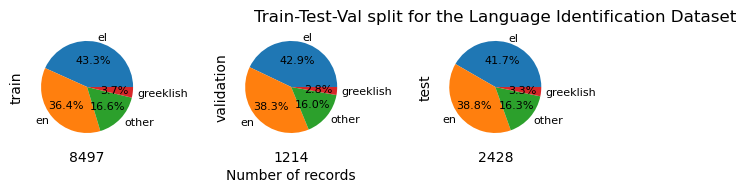

In [37]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.title("Train-Test-Val split for the Language Identification Dataset")
plt.tight_layout(pad=2.0)
plt.show()

We will encode our data as TF-IDF vectors. Count vectors could also work for this specific problem, but the computational cost of TF-IDF is minimal compared to acquiring the data fitting our classifiers.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because
    * We have an unbalanced dataset (Greeklish data are a small fraction of overall data)
    * We are much more interested in the small classes (here Greeklish)

Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [39]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

In [40]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    """
    Minor utility method printing average Macro F1 score and classification report
    as well as displaying the classifier's Confusion Matrix.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

For the Language Identification task the following models are considered:

- The previously implemented rules-based (Regex) model
- Naive Bayes
- Logistic Regression
- Random Forest
- Adaboost Model

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

Macro F1: 0.14709302325581394
              precision    recall  f1-score   support

          el       0.42      1.00      0.59      1012
          en       0.00      0.00      0.00       942
   greeklish       0.00      0.00      0.00        79
       other       0.00      0.00      0.00       395

    accuracy                           0.42      2428
   macro avg       0.10      0.25      0.15      2428
weighted avg       0.17      0.42      0.25      2428



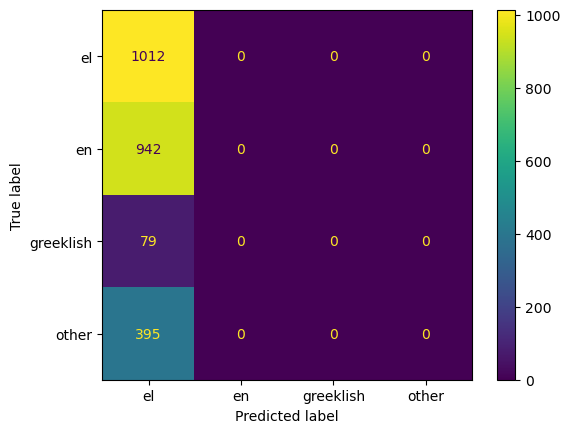

In [41]:
from sklearn.dummy import DummyClassifier


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

Let's now compare our rules-based classifier with the baseline. This classifier does use the input features to make decisions, but in a very simple and naive way. It also does not benefit from any information that could be gained through training.

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5690, std: 0.5614


Macro F1: 0.5427840052990762
              precision    recall  f1-score   support

          el       1.00      0.69      0.82      1012
          en       0.74      1.00      0.85       942
   greeklish       0.00      0.00      0.00        79
       other       0.98      0.34      0.51       395

    accuracy                           0.73      2428
   macro avg       0.68      0.51      0.54      2428
weighted avg       0.86      0.73      0.75      2428



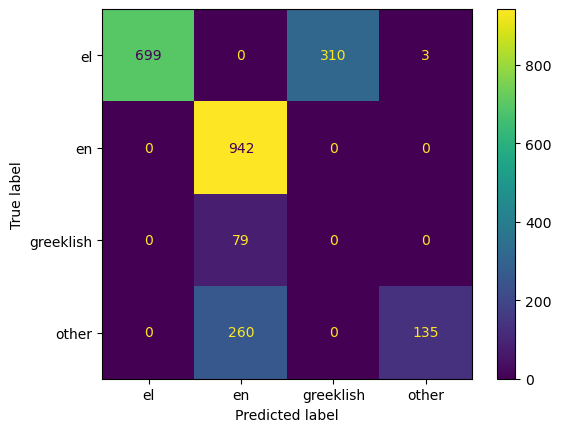

In [43]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

We notice that this classifiers performs relatively well at classifiying Greek and English, but is generally easily confused and can not catch Greeklish at all.

### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

In [44]:
from sklearn.naive_bayes import MultinomialNB

# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train, cv=5)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.7848, std: 0.8102


Macro F1: 0.8651470835475744
              precision    recall  f1-score   support

          el       0.92      1.00      0.96      1012
          en       0.96      1.00      0.98       942
   greeklish       1.00      0.47      0.64        79
       other       0.99      0.80      0.88       395

    accuracy                           0.95      2428
   macro avg       0.97      0.82      0.87      2428
weighted avg       0.95      0.95      0.94      2428



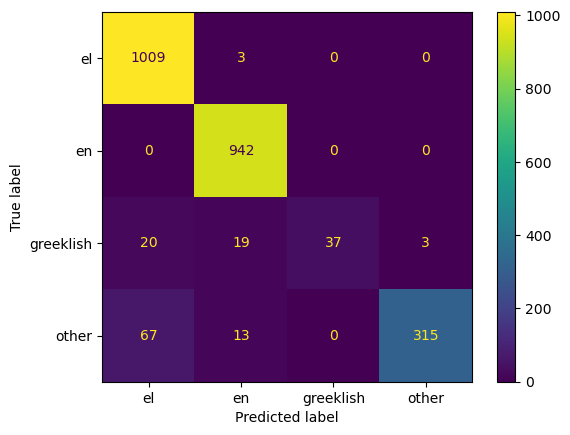

In [45]:
naive_model = MultinomialNB().fit(naive_x_train, y_train)
naive_res = naive_model.predict(naive_x_test)

get_statistics(y_test, naive_res)

Compared to our rules-based classifier, this is a great step-up. Classification of Greek and English is very good, and the "other" languages are reliably identified. 

Greeklish however are not reliably caught. The classification report states that when the classifier guesses Greeklish, it is always correct, but most Greeklish comments are confused with either English or Greek. Thus, the problem of distinguishing these three categories probably requires a more complex model.

### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [46]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.9042, std: 0.8825


Macro F1: 0.9243052241829711
              precision    recall  f1-score   support

          el       0.99      0.98      0.99      1012
          en       0.99      0.99      0.99       942
   greeklish       0.98      0.63      0.77        79
       other       0.90      1.00      0.95       395

    accuracy                           0.98      2428
   macro avg       0.97      0.90      0.92      2428
weighted avg       0.98      0.98      0.98      2428



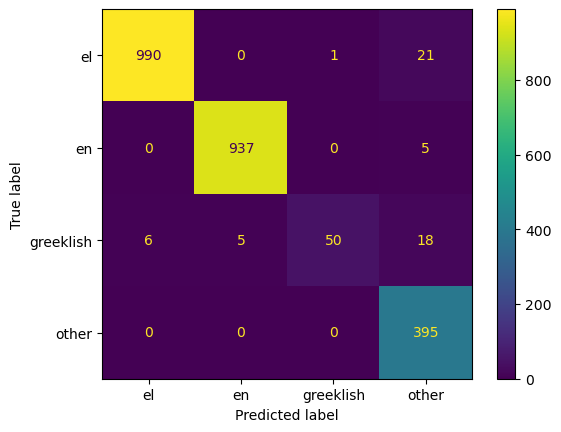

In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

These results are very encouraging, showing an almost excellent distinction between Greek and English and "Others" and a reliable classification of Greeklish.

### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [48]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=500, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9292, std: 0.9111


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   30.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.4s finished


Macro F1: 0.9120798978330256
              precision    recall  f1-score   support

          el       0.91      1.00      0.95      1012
          en       0.99      1.00      0.99       942
   greeklish       0.90      0.80      0.85        79
       other       0.99      0.76      0.86       395

    accuracy                           0.95      2428
   macro avg       0.95      0.89      0.91      2428
weighted avg       0.95      0.95      0.95      2428



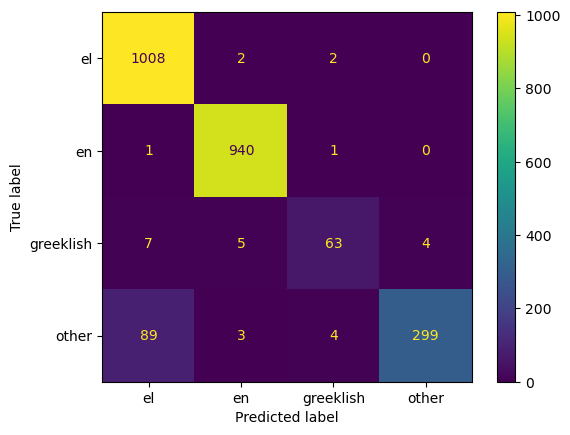

In [49]:
forest_model = RandomForestClassifier(n_estimators=500, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

The results are somewhat similar to our Logistic Regression classifier. The Cross-Validation score reports an equal on-average performance. 

### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [50]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.8230, std: 0.7829


Macro F1: 0.8173169647781657
              precision    recall  f1-score   support

          el       1.00      0.87      0.93      1012
          en       0.99      0.98      0.99       942
   greeklish       0.80      0.42      0.55        79
       other       0.68      0.98      0.80       395

    accuracy                           0.92      2428
   macro avg       0.87      0.81      0.82      2428
weighted avg       0.94      0.92      0.92      2428



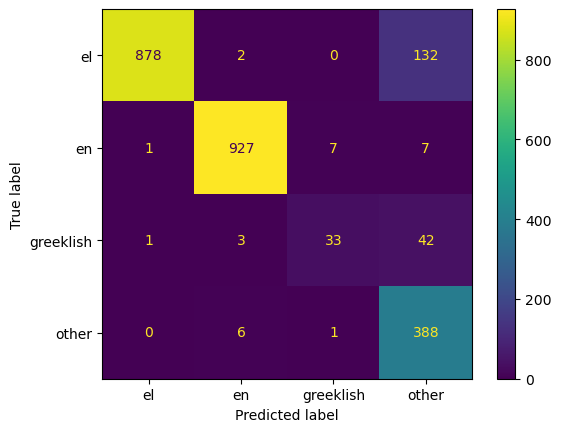

In [51]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

This classifier despite its complexity is even worse, being generally unable to distinguish Greeklish from "Other" languages and even placing many Greek comments to the latter category.

This can be clearly seen by looking at the misclassification of adaboost compared to the misclassification of Random Forest.

In [52]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
1373,greeklish,en,The lights look beautiful!
4411,other,el,"Στην εταιρεία χρηματοπιστωτικών υπηρεσιών , η ..."
4060,other,el,Αυτός ήταν ο μπαμπάς μου .
2679752,other,greeklish,old expancion lordaeron server litch king
410,other,el,Περαστικά
...,...,...,...
4193,other,el,6 % ως αποτέλεσμα απροσδιόριστο μόνιμων δράσεω...
1568,other,el,Αυτό κάνει ο καπιταλισμός της αγοράς .
2577,other,el,Εντάξει λοιπόν καλή σας νύχτα
4773,other,el,Ο θείος της νταν ήταν δέκα χρόνια μεγαλύτερος ...


In [53]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
9602,el,other,前にもセットで購入したのですがグリップ無くてもって思って弟にあげちゃいましたが、やっぱりあっ...
9632,el,other,"Syria ""zgłosić broń chemiczną i podpisać konwe..."
10505,el,other,Pakistańscy talibowie wyznaczają nowego przywó...
9644,el,other,Оба окончательных правила были изданы кцб в со...
9118,el,other,Dali-schilderij gestolen uit galerie
...,...,...,...
533,en,greeklish,Warwick greek voice is actor is da best
10503,el,other,2019.07.03にこちらで購入して、数回使用して故障しました！商品自体はよかったですが、...
10865,el,other,เอ่อ ทำไมคุณไม่เริ่มต้นล่ะ เพราะว่าคุณมีเวลามา...
10561,el,other,Hapana shaka rudisha .


### Hyperparameter tuning

Despite the allure of Logistic Regression's properties, we will stick to the more complex model of Random Forest, since we anticipate that the sample we procured for training and testing may not necessarily be very close to the actual operational data. We thus value the stability and robustness of a non-parametric method than the computational complexity and theoretical benefits of Logistic Regression.

Since training Random Forest models is computationally intensive, we will only execute hyperparameter tuning on the most significant hyper-parameter; the number of trees which will vote during testing. This is also where our validation set comes into play.

In [54]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:11<00:00, 43.19s/it]


In [55]:
best_model = estimators[np.argmax(scores)]
print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_estimators=977, n_jobs=-1) with macro F1 score of 0.9372640339591569


### Annotating the operational dataset

We use our optimal classifier to identify the language of our operational dataset, which in this case are the crawled YouTube comments:

In [56]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)
crawl_df

,title,link,source,text,date,language
0,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,ANTIGUAS CANCIONES DE GRECIA PAIS NATAL DE MIS...,2022-11-29,other
1,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-29,el
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,FelicităriSuperb \nSă fiți mereu bine \nMomen...,2022-11-29,greeklish
3,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Lovely collection! Thank you <3,2022-11-29,greeklish
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Beautiful thank you so many memories awesome ...,2022-11-29,en
...,...,...,...,...,...,...
2692,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Copy by fantaros,2021-11-29,el
2693,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Fist,2021-11-29,el
2694,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Yui,2022-11-29,el
2695,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Uihhii,2022-11-29,el


### Exploring the operational dataset

Now that we have annotated to the best of our abilities the operational dataset, it's time to run some quick analysis on our findings. 

The analysis and descriptions can be found in the `report.pdf` file. This notebook will only generate the graphs and Figures used there.

In [57]:
RESOURCE_OUTPUT = "results"

def save_plot(filename):
    path = os.path.join(RESOURCE_OUTPUT, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

#### Total language frequency

In [58]:
# Define a common color palette for all graphs
palette = {"el": "blue", "en": "red", "greeklish": "green", "other": "black"}

C:\Users\user\AppData\Local\Temp\ipykernel_32116\3670115791.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(crawl_df.language, palette=palette, legend=False)


Figured saved to results\lang_dis.png


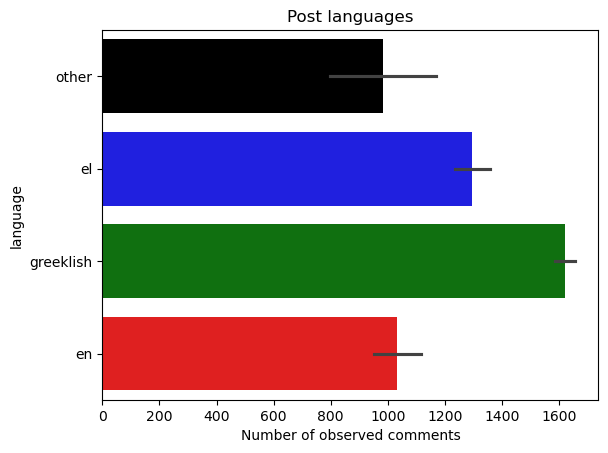

In [59]:
import seaborn as sns


# I really don't have time to fix this warning, sorry :(
sns.barplot(crawl_df.language, palette=palette, legend=False)
plt.title("Post languages")
plt.xlabel("Number of observed comments")

save_plot("lang_dis.png")
plt.show()

#### Average length of comments by language

In [60]:
languages = np.unique(crawl_df.language)

lang_col = []
len_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(x))
    
    lang_col += [language] * len(comments_length)
    len_col += list(comments_length)

len_df = pd.DataFrame({"language": lang_col, "comment_length": len_col})

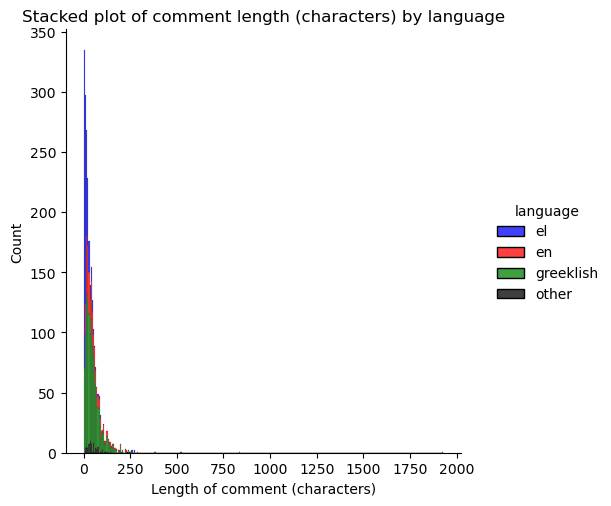

In [61]:
sns.displot(len_df, x="comment_length", hue="language", multiple="stack", palette=palette)
plt.title("Stacked plot of comment length (characters) by language")
plt.xlabel("Length of comment (characters)")
plt.show()

The wild variations between the main distribution and its long tail make parsing the graph very difficult. We will thus split it in two graphs, one containing the main body of the distribution and the other the long tail.

Figured saved to results\length_dis.png


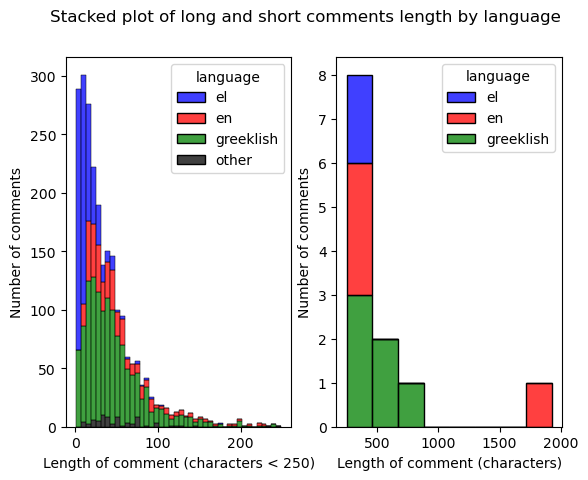

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(len_df[len_df.comment_length<=250],
             x="comment_length", 
             hue="language", 
             multiple="stack", 
             palette=palette,
             ax=ax1)
ax1.set_xlabel("Length of comment (characters < 250)")
ax1.set_ylabel("Number of comments")

sns.histplot(len_df[len_df.comment_length>250], 
             x="comment_length", 
             hue="language", 
             multiple="stack",
             palette=palette,
             ax=ax2)
ax2.set_xlabel("Length of comment (characters)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of long and short comments length by language")
save_plot("length_dis.png")
plt.show()

#### Emoji usage by language

In [63]:
emoji_pattern = re.compile(
    r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF'
    r'\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF'
    r'\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\u2600-\u26FF\u2700-\u27BF'
    r'\u2B50\u2B06\u2934\u2935\u2B05\u2194-\u2199\u21A9\u21AA\u2139\u2328'
    r'\u23CF\u23E9-\u23F3\u231A\u23F8-\u23FA\u231B\u23F0\u231A\u1F004'
    r'\u1F0CF\u1F18E\u3030\u303D]', flags=re.UNICODE
)

emojis_col = []

for language in languages:
    comments_text = crawl_df.loc[crawl_df.language == language, "text"]
    comments_length = comments_text.apply(lambda x: len(emoji_pattern.findall(x)))

    emojis_col += list(comments_length)

emoji_df = pd.DataFrame({"language": lang_col, "emojis": emojis_col})

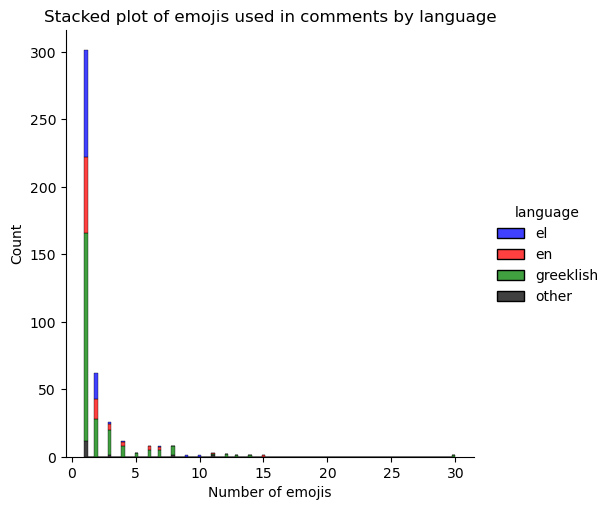

In [64]:
sns.displot(emoji_df[emoji_df.emojis > 0],
            x="emojis", 
            hue="language",
            multiple="stack",
            palette=palette)
plt.title("Stacked plot of emojis used in comments by language")
plt.xlabel("Number of emojis")
plt.show()

We will perform the same operation as above for the same reasons.

Figured saved to results\emojis_dis.png


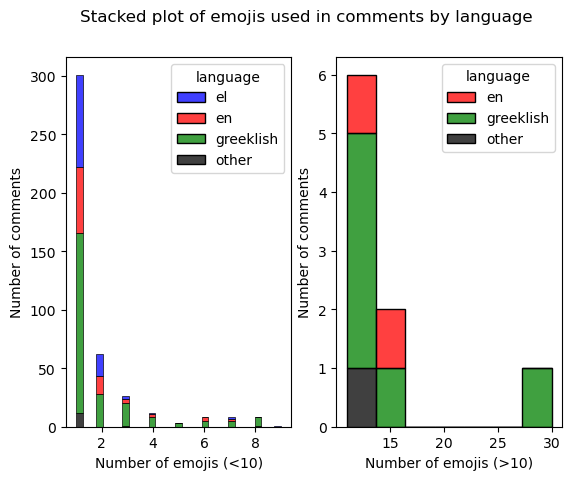

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(emoji_df[(emoji_df.emojis > 0) & (emoji_df.emojis < 10)],
             x="emojis",
             hue="language",
             multiple="stack",
             palette=palette,
             ax=ax1)
ax1.set_xlabel("Number of emojis (<10)")
ax1.set_ylabel("Number of comments")

sns.histplot(emoji_df[emoji_df.emojis > 10],
             x="emojis", 
             hue="language", 
             multiple="stack",
             palette=palette,
             ax=ax2)
ax2.set_xlabel("Number of emojis (>10)")
ax2.set_ylabel("Number of comments")

fig.suptitle("Stacked plot of emojis used in comments by language")
save_plot("emojis_dis.png")
plt.show()

#### Observed language usage through time

In [66]:
date_df = crawl_df.groupby(["date", "language"]).count()
date_df

title  link  source  text
date       language                            
2018-11-29 el             3     3       3     3
           en             1     1       1     1
2019-11-29 el            49    49      49    49
           en            38    38      38    38
           greeklish    231   231     231   231
...                     ...   ...     ...   ...
2023-11-28 el             5     5       5     5
           en             3     3       3     3
           greeklish      2     2       2     2
           other          1     1       1     1
2023-11-29 greeklish      1     1       1     1

[107 rows x 4 columns]

In [67]:
date_df2 = date_df.reset_index()
date_df2.date = pd.to_datetime(date_df2.date)
date_df2.date

0     2018-11-29
1     2018-11-29
2     2019-11-29
3     2019-11-29
4     2019-11-29
         ...    
102   2023-11-28
103   2023-11-28
104   2023-11-28
105   2023-11-28
106   2023-11-29
Name: date, Length: 107, dtype: datetime64[ns]

Figured saved to results\time_plot.png


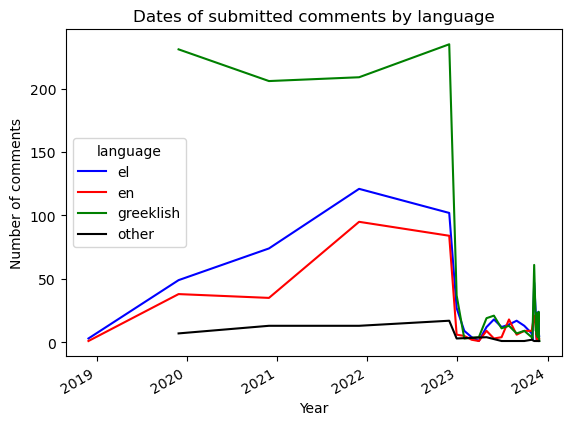

In [68]:
import matplotlib.dates as mdates


sns.lineplot(x="date", 
             y="text",
             hue="language", 
             palette=palette,
             data=date_df2)

plt.title("Dates of submitted comments by language")
plt.xlabel("Year")
plt.ylabel("Number of comments")

plt.gcf().autofmt_xdate()
plt.gca().fmt_xdata = mdates.DateFormatter('%Y-%m')

save_plot("time_plot.png")
plt.show()

## Toxicity Classification

We will now attempt to build a Toxicity Classifier using an LLM. The process, prompts and decisions of this classifier can be found in the `prompts.pdf` report. Note that due to the project's restrictions we are only allowed to use data annotated by the LLM model.

### Importing the data

We will import the LLM's responses and build a dataframe out of them. The annotated dataset was derived from a sample of `gold.csv`, in order to avoid feeding the model operational data.

In [69]:
with open(os.path.join("data", "chatgpt_annot.txt"), "r", encoding="utf8") as file:
    raw_annot = file.read()

records = raw_annot.split("\n")
len(records), records[0]

(365,
 '"Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε! +1 όσοι είδαν το μπλουζάκι PDT p.s το AR το βάλαμε έτσι για συντομογραφία, εννοείται πως άλλο AR και άλλο τρίσφαιρο!" - 1')

In [70]:
annotations = [record.split("-") for record in records]

comments = []
values = []
for annotation in filter(lambda x: len(x) != 1, annotations):
    comment = annotation[0]
    value = int(annotation[1])
    comments.append(comment)
    values.append(value)

In [71]:
toxicity_df = pd.DataFrame({"comments": comments, "toxicity": values})
toxicity_df

,comments,toxicity
0,"""Εαν σας άρεσε κάντε Like ρεεε μη ντρέπεστε! +...",1
1,"""Φήμες λένε ότι ο Gianuba βάζει καρδούλες ️""",1
2,"""Congrats on your channel , que venha o 1 milh...",1
3,"""ΤΟΣΑ ΤΕΛΕΙΑ ΒΙΝΤΕΟ ΘΑ ΚΑΝΕΙ Ο GIANOUBA22""",1
4,"""Η φάση που ο gianuba 22 φοράει μπλούζα pdt nu...",1
...,...,...
178,"Ψάχνουμε άτομα για raid Παρασκευή 9:00, Σάββατ...",3
179,Μήπως παίζατε καθόλου στον παλιό Neltharion πρ...,4
180,Σε Horde ή Alliance θα είναι το guild;,1
181,Υπάρχει κανένα active ελληνικό guild από πλευρ...,1


Our dataset is comprised of 182 comments. These are of course way too few for any NLP task, but due to resource constraints and those placed by ChatGPT's frontend is the best sample we can acquire.

Our sample attempted to be as representative as possible, including data from all language categories as uniformally as possible, as well as purposefully including many toxic comments.

The overall distribution of labels produced by ChatGPT can be seen below:

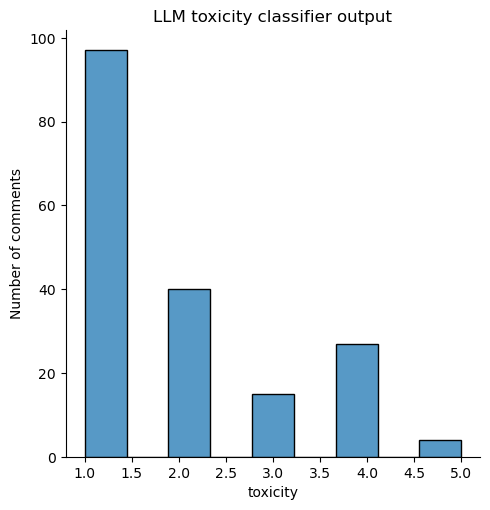

In [72]:
sns.displot(toxicity_df.toxicity)
plt.title("LLM toxicity classifier output")
plt.ylabel("Number of comments")
plt.show()

### Data Transformation

We will now repeat the procedure for training the same models as above. We will not be including a validation set because of the critically low amount of data we have at our disposal.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(toxicity_df, random_state=42)
# new vectorizer because of new data
vectorizer = TfidfVectorizer().fit(data_train.comments)
x_train = vectorizer.transform(data_train.comments)
y_train = data_train.toxicity
x_test = vectorizer.transform(data_test.comments)
y_test = data_test.toxicity

### Model Selection

#### Dummy Classifier

Macro F1: 0.1408450704225352
              precision    recall  f1-score   support

           1       0.54      1.00      0.70        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.11      0.20      0.14        46
weighted avg       0.30      0.54      0.38        46



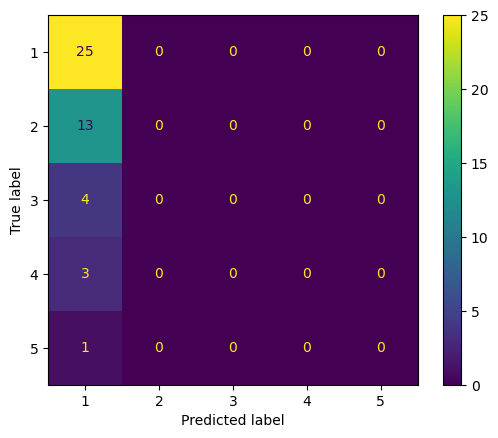

In [74]:
from sklearn.dummy import DummyClassifier


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

#### Naive Bayes

In [75]:
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train, cv=5)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.2797, std: 0.1395


C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Macro F1: 0.21913043478260869
              precision    recall  f1-score   support

           1       0.55      0.96      0.70        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.26      0.22        46
weighted avg       0.33      0.54      0.40        46



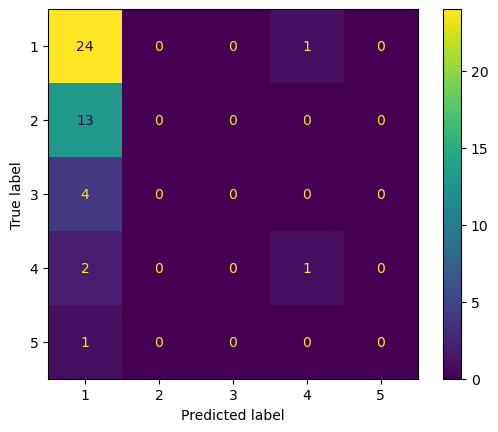

In [76]:
naive_model = MultinomialNB().fit(naive_x_train, y_train)
naive_res = naive_model.predict(naive_x_test)

get_statistics(y_test, naive_res)

#### Logistic Regression

In [77]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.1818, std: 0.4605


Macro F1: 0.21913043478260869
              precision    recall  f1-score   support

           1       0.55      0.96      0.70        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.26      0.22        46
weighted avg       0.33      0.54      0.40        46



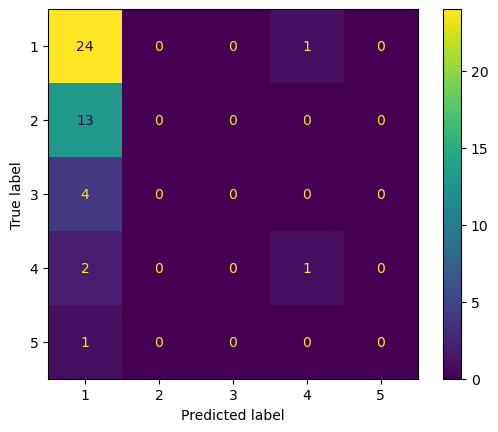

In [78]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

#### Random Forest

In [79]:
forest_model = RandomForestClassifier(n_estimators=200, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


Random Forest mean macro F1: 0.3092, std: 0.4472


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Macro F1: 0.22117647058823525
              precision    recall  f1-score   support

           1       0.56      0.96      0.71        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         1

    accuracy                           0.54        46
   macro avg       0.21      0.26      0.22        46
weighted avg       0.34      0.54      0.41        46



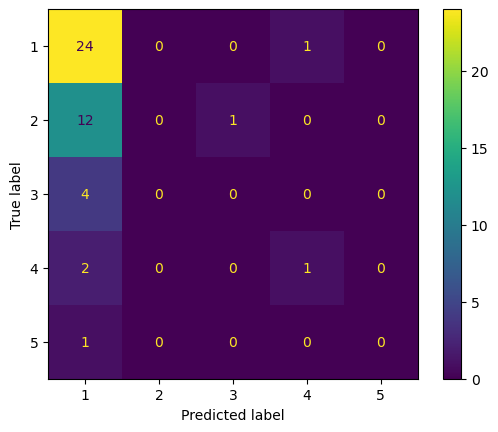

In [80]:
forest_model = RandomForestClassifier(n_estimators=200,
                                      n_jobs=-1,
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

#### Adaboost

In [81]:
ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.2347, std: 0.2274


Macro F1: 0.24285714285714288
              precision    recall  f1-score   support

           1       0.56      1.00      0.71        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         4
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         1

    accuracy                           0.57        46
   macro avg       0.31      0.27      0.24        46
weighted avg       0.37      0.57      0.42        46



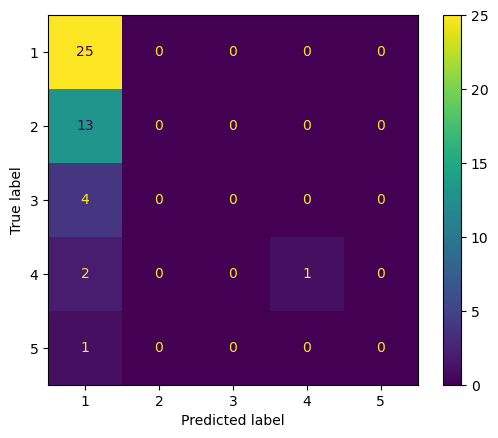

In [82]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

### Classifiying the crawled data

We can clearly see that none of our classifiers can make any meaningful guesses, being marginally better than a simple majority classifier, which is entirely the fault of our low amount of data. Because of the restrictions placed upon this project, we cannot augment this data in any meaningful way, and thus will continue the analysis with faulty classifiers.

In [83]:
crawl_df["toxicity"] = ada_model.predict(vectorizer.transform(crawl_df.text))
crawl_df

,title,link,source,text,date,language,toxicity
0,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,ANTIGUAS CANCIONES DE GRECIA PAIS NATAL DE MIS...,2022-11-29,other,1
1,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Încă o zi petrecută cu muzica voastră fantas...,2022-11-29,el,1
2,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,FelicităriSuperb \nSă fiți mereu bine \nMomen...,2022-11-29,greeklish,1
3,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Lovely collection! Thank you <3,2022-11-29,greeklish,1
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...,song,Beautiful thank you so many memories awesome ...,2022-11-29,en,1
...,...,...,...,...,...,...,...
2692,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Copy by fantaros,2021-11-29,el,1
2693,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Fist,2021-11-29,el,1
2694,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Yui,2022-11-29,el,1
2695,😱ΑΥΤΟΣ ΕΧΕΙ '0Views'(React Σε Montages Με '0'V...,https://www.youtube.com/watch?v=6ay2HZwz2sA&pp...,gaming,Uihhii,2022-11-29,el,1


### Analysing the Toxicity of crawled data

We will now execute the scripts necessary for the analysis available at `report.pdf`.

In [84]:
def export_to_latex(df, name, col_format, caption=None):
    """
    Export a pandas DataFrame to a LaTeX file.

    :param df: The DataFrame to be exported.
    :type df: pd.DataFrame

    :param name: The name of the LaTeX file (excluding the '.tex' extension).
    :type name: str

    :param col_format: A string specifying the column formatting for the LaTeX table.
    :type col_format: str

    :param caption: The caption for the LaTeX table (optional).
    :type caption: str, optional

    :return: This function does not return anything.
    """
    path = os.path.join(RESOURCE_OUTPUT, name)
    df.to_latex(buf=path,
                index=False,
                formatters={"name": str.upper},
                float_format="{:.3f}".format,
                label="tab::" + name.split(".")[0],
                caption=caption,
                escape=True,
               encoding="utf-8",
               column_format=col_format)
    print(f"Dataframe exported to {path}")


def remove_emojis(text):
    return emoji_pattern.sub(r'', text)

long_col_format = '|p{10cm}|p{1cm}|'

#### Finding the most toxic language

In [85]:
toxic_lang_df = crawl_df.loc[:, ["language", "toxicity"]].groupby("language").mean().reset_index()

caption = "Average toxicity by language."
export_to_latex(toxic_lang_df, "toxic_lang.tex", caption=caption, col_format="|p{3.5cm}|p{1cm}|")

toxic_lang_df

Dataframe exported to results\toxic_lang.tex


,language,toxicity
0,el,1.003053
1,en,1.117949
2,greeklish,1.004819
3,other,1.000000


#### Finding the most toxic video

In [86]:
toxic_videos_df = crawl_df.loc[:, ["link", "toxicity"]].groupby("link").mean().sort_values("toxicity", ascending=False)
toxic_videos_df

,toxicity
link,
https://www.youtube.com/watch?v=Iz1U4yxmRT4&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.500000
https://www.youtube.com/watch?v=2duliv41A1I&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.428571
https://www.youtube.com/watch?v=m7gGlw93Mq0&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.285714
https://www.youtube.com/watch?v=d-6Y4vE3g8U&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.250000
https://www.youtube.com/watch?v=ii2To2gvzkU&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.166667
...,...
https://www.youtube.com/watch?v=KLBYBvxiTvQ&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.000000
https://www.youtube.com/watch?v=JeNV28qWi_A&pp=ygUOZ3JlZWsgZm9ydG5pdGU%3D,1.000000
https://www.youtube.com/watch?v=HILSvOQV_bc&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D,1.000000


In [87]:
toxic_videos_df = toxic_videos_df.merge(
                    crawl_df.loc[:, ["link", "title"]].drop_duplicates(), 
                    on="link", 
                    how="inner").loc[:, ["title", "toxicity"]].head(5)

toxic_videos_df.title = toxic_videos_df.title.apply(lambda x: remove_emojis(x))
caption = "The top 5 videos with the most toxic comments on average."
export_to_latex(toxic_videos_df, "toxic_videos.tex", caption=caption, col_format=long_col_format)

toxic_videos_df

Dataframe exported to results\toxic_videos.tex


,title,toxicity
0,"Ρέμος: Αυτά όχι σε μένα, άσε τις μαγκιές",1.500000
1,Αγαπημένα Ελληνικά Τραγούδια / Greek Music Non...,1.428571
2,ΟΤΙ ΒΡΩ ΣΤΟ ORTNIT ΤΟ ΤΡΩΩ CHALLNG! (ortnite G...,1.285714
3,Δεν Μιλούν Για Τον Μπρούνο (Από το “Ενκάντο: Έ...,1.250000
4,Ένα τραγούδι η ζωή μας - 70 αγαπημένα τραγούδι...,1.166667


#### Finding videos where toxicity was uniform across time

In [88]:
# get the mean toxicity per day
toxic_time_df = crawl_df.loc[:, ["link", "date", "toxicity"]].groupby(["link", "date"]).mean().sort_values("toxicity", ascending=False)
toxic_time_df

toxicity
link                                               date                
https://www.youtube.com/watch?v=2duliv41A1I&pp=... 2022-12-29  4.000000
https://www.youtube.com/watch?v=Iz1U4yxmRT4&pp=... 2023-11-24  4.000000
https://www.youtube.com/watch?v=d-6Y4vE3g8U&pp=... 2023-06-29  2.000000
https://www.youtube.com/watch?v=q7elHOjAyEY&pp=... 2023-07-29  1.307692
https://www.youtube.com/watch?v=m7gGlw93Mq0&pp=... 2021-11-29  1.285714
...                                                                 ...
https://www.youtube.com/watch?v=JeNV28qWi_A&pp=... 2023-11-20  1.000000
                                                   2023-11-17  1.000000
                                                   2023-11-15  1.000000
https://www.youtube.com/watch?v=Iz1U4yxmRT4&pp=... 2023-11-28  1.000000
https://www.youtube.com/watch?v=zHQBNoNpmog&pp=... 2023-06-29  1.000000

[327 rows x 1 columns]

In [89]:
# get the std of each link according to all dates
toxic_time_var_df = toxic_time_df.groupby(["link", "toxicity"]).std().reset_index().sort_values("toxicity", ascending=True)
uniform_toxic_df = toxic_time_var_df[toxic_time_var_df.toxicity == 1]

# get video titles 
uniform_toxic_df = uniform_toxic_df.merge(
                    crawl_df.loc[:, ["link", "title"]].drop_duplicates(), 
                    on="link", 
                    how="inner").loc[:, ["title", "toxicity"]]

# remove emojis to be nice to latex
uniform_toxic_df.title = uniform_toxic_df.title.apply(lambda x: remove_emojis(x))
caption = "Videos where comment toxicity stayed uniform over time."
# only export 30 videos (to fit in latex table)
export_to_latex(uniform_toxic_df.head(30), "toxic_uniform.tex", caption=caption, col_format=long_col_format)

uniform_toxic_df

Dataframe exported to results\toxic_uniform.tex


,title,toxicity
0,Greek Music Mix 2021 - Ελληνικα Τραγουδια Mix ...,1.0
1,ΠΩΣ ΕΧΑΣΑ 100€ ΣΤΟ ORTNIT! *15.000 VBUCKS* (or...,1.0
2,Ένα τραγούδι η ζωή μας - 70 αγαπημένα τραγούδι...,1.0
3,ΚΑΘΕ KILL ΑΛΛΑΖΩ ΠΛΗΚΤΡΟΛΟΓΙΟ CHALLNG! (ortnit...,1.0
4,Ελληνικό Έντεχνο - λαφρολαϊκό mix,1.0
...,...,...
108,ΕΠΙΚΗ ΠΡΩΤΗ ΝΙΚΗ ΣΤΟ ORTNIT ft Alex (LPDudes) ...,1.0
109,ΓΙΑ ΚΑΘΕ DATH ΤΡΩΩ ΚΑΥΤΕΡΗ ΚΟΤΟΜΠΟΥΚΙΑ! (ortni...,1.0
110,Νατάσα Θεοδωρίδου - Αν πας με άλλη (AI Cover),1.0
111,"Ρέμος: Αυτά όχι σε μένα, άσε τις μαγκιές",1.0


#### Finding videos where toxicity increases over time

In [90]:
toxic_time_incr_df = crawl_df.loc[:,["link", "date", "toxicity"]].copy()
# sort by date
toxic_time_incr_df = toxic_time_incr_df.sort_values("date")
# get lag 1 difference between dates
toxic_time_incr_df["toxicity_diff"] = toxic_time_incr_df.toxicity.diff()
# find where toxicity increases
toxic_time_incr_df = toxic_time_incr_df.loc[toxic_time_incr_df.toxicity_diff > 0, :]
# get mean growth of toxicity along the dates
toxic_time_incr_df = toxic_time_incr_df.loc[:, ["link", "toxicity_diff"]].groupby("link").mean()
# print most toxic videos sorted by toxicity
toxic_time_incr_df = toxic_time_incr_df.reset_index().sort_values("toxicity_diff", ascending=False)
toxic_time_incr_df

,link,toxicity_diff
0,https://www.youtube.com/watch?v=0sTegFKn-nQ&pp...,3.000000
1,https://www.youtube.com/watch?v=2duliv41A1I&pp...,3.000000
5,https://www.youtube.com/watch?v=Iz1U4yxmRT4&pp...,3.000000
6,https://www.youtube.com/watch?v=ZTJPZJ453dY&pp...,3.000000
7,https://www.youtube.com/watch?v=b-GnJoG6VE8&pp...,3.000000
13,https://www.youtube.com/watch?v=tGSLjD2YJCY&pp...,3.000000
14,https://www.youtube.com/watch?v=z4DMFzyCkP0&pp...,3.000000
9,https://www.youtube.com/watch?v=ii2To2gvzkU&pp...,2.500000
8,https://www.youtube.com/watch?v=d-6Y4vE3g8U&pp...,2.333333
2,https://www.youtube.com/watch?v=7wuh7H_PabI&pp...,2.000000


In [91]:
toxic_time_incr_df = toxic_time_incr_df.merge(
                    crawl_df.loc[:, ["link", "title"]].drop_duplicates(), 
                    on="link", 
                    how="inner").loc[:, ["title", "toxicity_diff"]]


toxic_time_incr_df.title = toxic_time_incr_df.title.apply(lambda x: remove_emojis(x))
caption = "Videos where comment toxicity stayed increased over time."\
            "The toxicity\_diff represents the average difference between comment toxicity"\
            "with lag 1 across each date."
export_to_latex(toxic_time_incr_df, "toxic_increasing.tex", caption=caption, col_format=long_col_format)

toxic_time_incr_df

Dataframe exported to results\toxic_increasing.tex


,title,toxicity_diff
0,Greek Music Mix 2021 - Ελληνικα Τραγουδια Mix ...,3.000000
1,Αγαπημένα Ελληνικά Τραγούδια / Greek Music Non...,3.000000
2,"Ρέμος: Αυτά όχι σε μένα, άσε τις μαγκιές",3.000000
3,ΣΚΟΤΩΣΑ ΤΟΝ MONGRAAL M 2OBOMB !,3.000000
4,ΑΝ ΓΕΛΑΣΕΙΣ ΧΑΝΕΙΣ 500 VBUCKS! (ortnite unny M...,3.000000
5,Δοκίμασα 30 PS στο UNRAL RANK...,3.000000
6,Ελαφρολαϊκά παλιά - 120 μεγάλες επιτυχίες (by ...,3.000000
7,Ένα τραγούδι η ζωή μας - 70 αγαπημένα τραγούδι...,2.500000
8,Δεν Μιλούν Για Τον Μπρούνο (Από το “Ενκάντο: Έ...,2.333333
9,ΝΙΚΗ ΜΟΝΟ ΜΕ ΜΥΘΙΚΑ ΟΠΛΑ CHALLNG! (ortnite Greek),2.000000


## Exporting the operational dataset

In [92]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


**Thanks for following along!**

In [93]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 51 minutes and 9.0 seconds
